# **\[SOLAR_A\]** 시뮬레이션 코드정리

JiyunLim  
2023-08-16

# 시뮬레이션 코드정리

## Import

In [1]:
# modules 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import eptstgcn
import torch_geometric_temporal
from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal
import mplcyberpunk

# torch
import torch
import torch.nn.functional as F
#import torch_geometric_temporal
from torch_geometric_temporal.nn.recurrent import GConvGRU
# from torch_geometric_temporal.nn.recurrent import GConvLSTM
# from torch_geometric_temporal.nn.recurrent import GCLSTM
# from torch_geometric_temporal.nn.recurrent import LRGCN
# from torch_geometric_temporal.nn.recurrent import TGCN
# from torch_geometric_temporal.nn.recurrent import DCRNN

# read data
def makedict(FX,W=None,node_ids=None):
    T,N = np.array(FX).shape
    if W==None:
        W = pd.DataFrame(FX).corr().to_numpy().reshape(-1).tolist() # corr 로 weights
    if node_ids==None:
        node_ids = ['node'+str(n) for n in range(N)]
    _dict={
        'edges':[[i,j] for i in range(N) for j in range(N)], 
        'node_ids': node_ids,
        'weights':W,
        'FX':FX
    }
    return _dict

class Loader(object):
    def __init__(self, data_dict):
        self._dataset = data_dict
    
    def _get_edges(self):
        self._edges = np.array(self._dataset["edges"]).T

    def _get_edge_weights(self):
        # self._edge_weights = np.array(self._dataset["weights"]).T
        edge_weights = np.array(self._dataset["weights"]).T
        #scaled_edge_weights = minmaxscaler(edge_weights)
        self._edge_weights = edge_weights

    def _get_targets_and_features(self):
        stacked_target = np.stack(self._dataset["FX"])
        self.features = np.stack([
            stacked_target[i : i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])
        self.targets = np.stack([
            stacked_target[i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])


    def get_dataset(self, lags: int = 4) -> StaticGraphTemporalSignal:
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = StaticGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        dataset.node_ids = self._dataset['node_ids']
        return dataset
    

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

class RGCN_Learner:
    def __init__(self):
        self.method = 'RecurrentGCN'
        self.figs = []
        self.epochs = 0
        self.losses = []
        self._node_idx = 0
    def load(self,y): 
        if (self.lags is None) or (self.train_ratio is None):
            self.lags = 2 
            self.train_ratio = 0.8 
        self.t,self.n = y.shape
        dct = makedict(FX=y.tolist())
        self.loader = Loader(dct)
        self.dataset = self.loader.get_dataset(lags=self.lags)
        self.X = torch.tensor(self.dataset.features).float()
        self.y = torch.tensor(self.dataset.targets).float()
        self.train_dataset, self.test_dataset = eptstgcn.utils.temporal_signal_split(self.dataset, train_ratio = self.train_ratio)
        self.len_test = self.test_dataset.snapshot_count
        self.len_tr = self.train_dataset.snapshot_count
        #self.dataset_name = str(self.train_dataset) if dataset_name is None else dataset_name
        # self.train_dataset_batch = torch.utils.data.DataLoader(self.train_dataset,batch_size=256)
    def get_batches(self, batch_size=256):
        num_batches =  self.len_tr // batch_size + (1 if self.len_tr % batch_size != 0 else 0)
        self.batches = []
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            self.batches.append(self.train_dataset[start_idx:end_idx])
    
    def learn(self,epoch=1):
        self.model.train()
        for e in range(epoch):
            losses_batch = []
            for b,batch in enumerate(self.batches):
                loss = 0
                # self.h, self.c = None, None
                for t, snapshot in enumerate(batch):
                    snapshot = snapshot.to(device)
                    # yt_hat, self.h, self.c = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)
                    yt_hat = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
                    loss = loss + torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                    print(f'\rbatch={b}\t t={t+1}\t loss={loss/(t+1)}\t', end='', flush=True)
                loss = loss / (t+1)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                losses_batch.append(loss.item())
            self.epochs = self.epochs + 1
            print(f'\repoch={self.epochs}\t loss={np.mean(losses_batch)}\n', end='', flush=True)
        self.losses.append(np.mean(losses_batch))
        self._savefigs() 
    def _savefigs(self): 
        self.__call__()
        self._node_idx
        with plt.style.context('default'): 
            plt.ioff()
            plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
            fig,ax = plt.subplots()
            ax.plot(self.y[:,self._node_idx],label='real',lw=0.5)
            ax.plot(self.yhat[:,self._node_idx],'--',label='predited',alpha=0.5)
            ax.set_title(f'Epoch={self.epochs}, node_idx={self._node_idx}',size=15)
            ax.legend()
            #mplcyberpunk.add_glow_effects()  
        self.figs.append(fig)
        plt.close()
    def __call__(self,dataset=None):
        if dataset == None: 
            dataset = self.dataset
        self.yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr) for snapshot in dataset]).detach().squeeze().float()
        return {'X':self.X, 'y':self.y, 'yhat':self.yhat} 

# learn 
# def rgcn(FX,train_ratio,lags,filters,epoch):
#     dct = makedict(FX=FX.tolist())
#     loader = Loader(dct)
#     dataset = loader.get_dataset(lags=lags)
#     dataset_tr, dataset_test = eptstgcn.utils.temporal_signal_split(dataset, train_ratio = train_ratio)
#     lrnr = RGCN_Learner(dataset_tr, dataset_name = 'org & arbitrary')
#     lrnr.learn(filters=filters, epoch=epoch)
#     yhat = np.array(lrnr(dataset)['yhat'])
#     yhat = np.concatenate([np.array([list(yhat[0])]*lags),yhat],axis=0) # lag만큼 0으로
#     return yhat

In [2]:
# FX = y

# GConvGRU

In [3]:
class GConv_GRU(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(GConv_GRU, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

## Load data

In [4]:
# read dataframe 
df = pd.read_csv('data_eng_230710.csv')

# make y, y_upper, y_period, time, regions 
y = df.loc[:,'Bukchoncheon':'Gyeongju-si'].to_numpy()
yU = df.loc[:,'Bukchoncheon_Upper':'Gyeongju-si_Upper'].to_numpy()
yP = np.divide(y, yU+1e-10)

t = df.loc[:,'date']
regions = list(df.loc[:, 'Bukchoncheon':'Gyeongju-si'].columns)

In [5]:
# global parameters
TRAIN_RATIO = 0.8
T, N = len(t), len(regions)
LEN_TEST = int(np.floor(T*(1-TRAIN_RATIO)))
LEN_TR = T - LEN_TEST

## sample_codes

`-` 예시1: y를 학습

**학습~**

In [84]:
# step1: create lrnr object
lrnr = RGCN_Learner()
# step2: load data 
lrnr.lags = 4 
lrnr.train_ratio = 0.8
lrnr.load(y) 
# step3: construct networks 
lrnr.nof_filters = 16
lrnr.model = GConv_GRU(node_features=lrnr.lags, filters=lrnr.nof_filters).to(device)
lrnr.optimizer = torch.optim.Adam(lrnr.model.parameters(),lr=10/1000)
# step4: learn 
lrnr.get_batches(batch_size=24)
for e in range(5):    
    lrnr.learn()

epoch=1  loss=0.413030183765777382193756    
epoch=2  loss=0.113235484722048749121094        
epoch=3  loss=0.10344353461161603903015         
epoch=4  loss=0.098992302407358976771545        
epoch=5  loss=0.096660999104727141616974        

In [188]:
yhat = np.concatenate([np.array([list(lrnr.yhat[0])]*lrnr.lags),lrnr.yhat],axis=0)
yhat[yhat<0] = 0

In [184]:
((lrnr.y - lrnr.yhat)**2).mean()

In [189]:
np.mean((y - yhat)**2)

In [86]:
node_idx = 0
epochs = 5

In [88]:
y.shape, yhat.shape

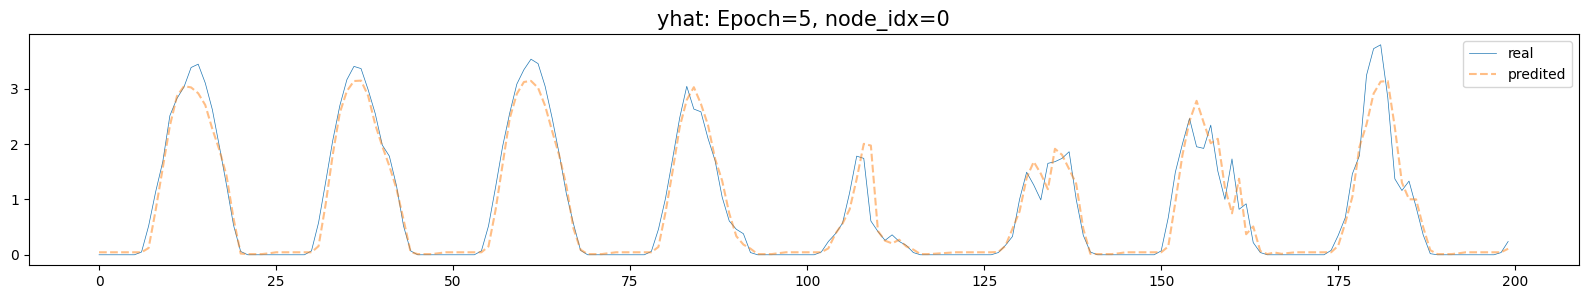

In [190]:
with plt.style.context('default'): 
        plt.ioff()
        plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
        fig,ax = plt.subplots()
        plt.plot(y[:200,node_idx],label='real',lw=0.5)
        plt.plot(yhat[:200,node_idx],'--',label='predited',alpha=0.5)
        ax.set_title(f'yhat: Epoch={epochs}, node_idx={node_idx}',size=15)
        ax.legend()

**에폭별 적합결과($\hat{y}$) 시각화**

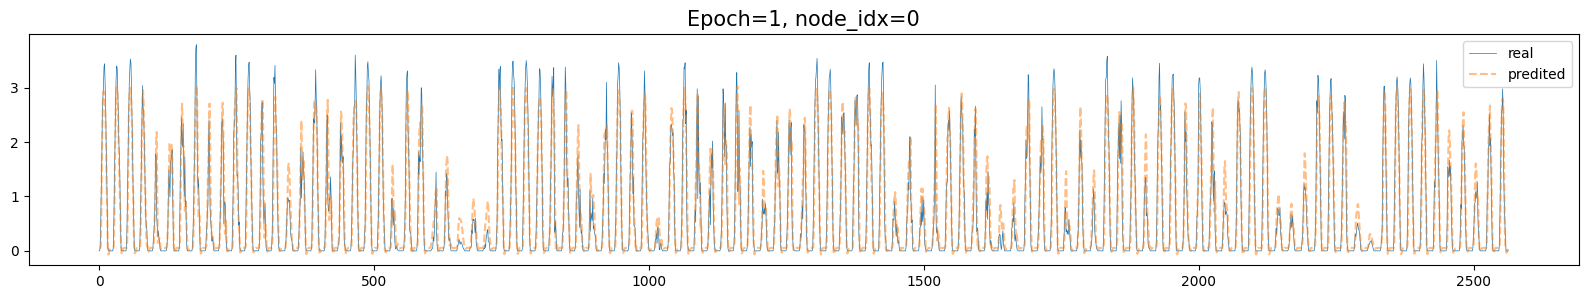

In [41]:
lrnr.figs[0]

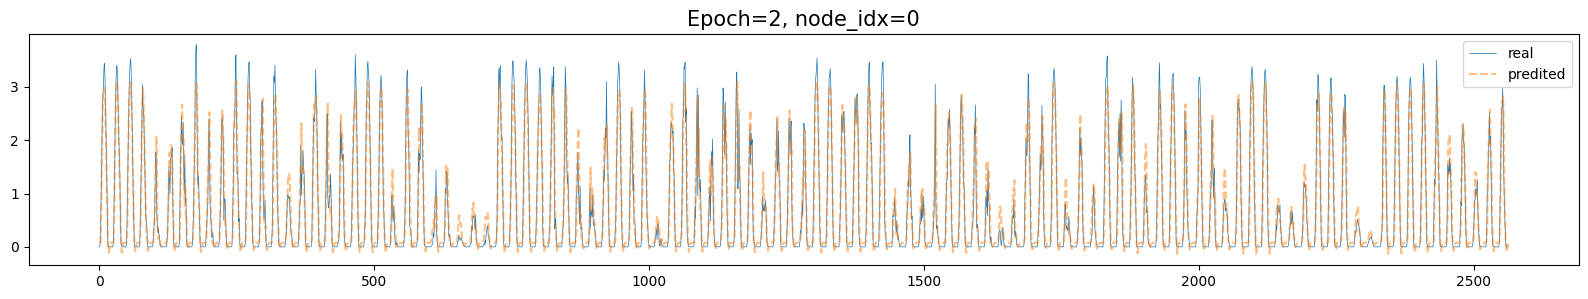

In [6]:
lrnr.figs[1]

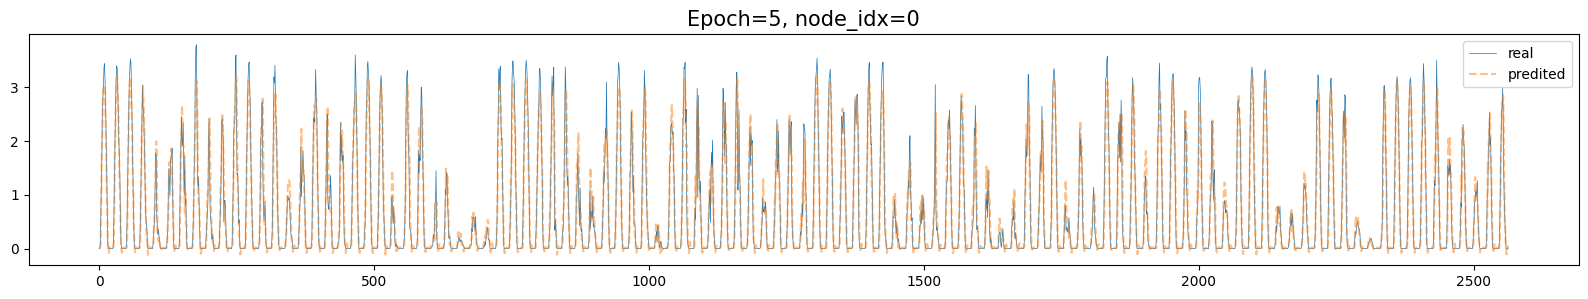

In [7]:
lrnr.figs[-1]

`-` 예시2: yU 학습

In [44]:
# step1: create lrnr object
lrnr = RGCN_Learner()
# step2: load data 
lrnr.lags = 4 
lrnr.train_ratio = 0.8
lrnr.load(yU) 
# step3: construct networks 
lrnr.nof_filters = 16
lrnr.model = GConv_GRU(node_features=lrnr.lags, filters=lrnr.nof_filters).to(device)
lrnr.optimizer = torch.optim.Adam(lrnr.model.parameters(),lr=10/1000)
# step4: learn 
lrnr.get_batches(batch_size=24)
for e in range(5):    
    lrnr.learn()

epoch=1  loss=1.778752895765183682937622        
epoch=2  loss=0.0788086586263637138075256   
epoch=3  loss=0.0519640686228698067373085   
epoch=4  loss=0.0414563097752804187227726       
epoch=5  loss=0.0361564866115534390203953   

In [202]:
# yUhat_ = lrnr.yhat
yUhat = np.concatenate([np.array([list(yUhat_[0])]*lrnr.lags),yUhat_],axis=0)

In [204]:
yUhat.shape

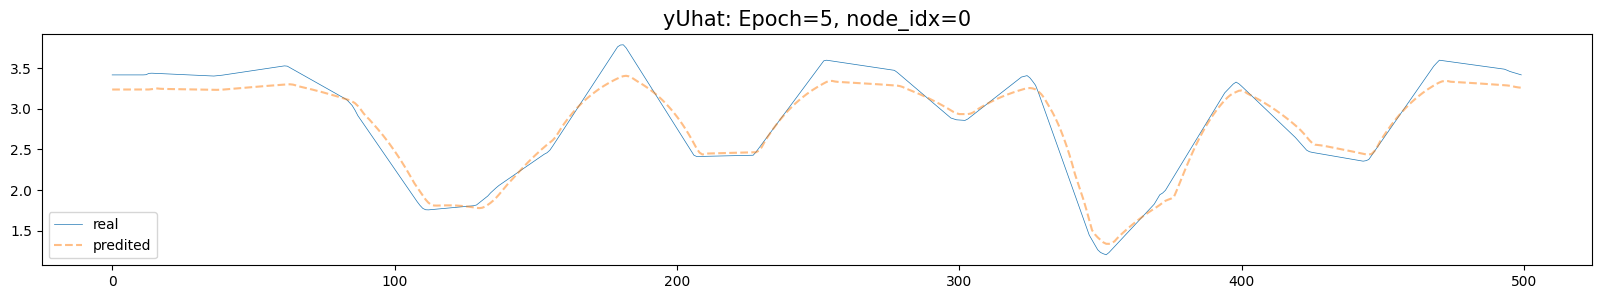

In [205]:
with plt.style.context('default'): 
        plt.ioff()
        plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
        fig,ax = plt.subplots()
        plt.plot(yU[:t_,node_idx],label='real',lw=0.5)
        plt.plot(yUhat[:t_,node_idx],'--',label='predited',alpha=0.5)
        ax.set_title(f'yUhat: Epoch={epochs}, node_idx={node_idx}',size=15)
        ax.legend()

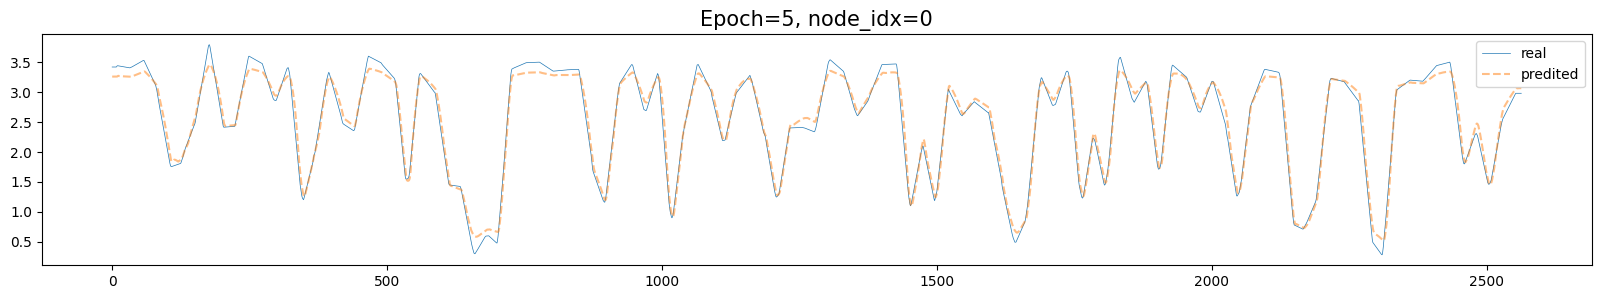

In [11]:
lrnr.figs[-1]

5번정도 더 돌려보자

In [ ]:
# for e in range(5):    
#     lrnr.learn()

In [ ]:
# lrnr.figs[-1]

`-` 예시3: yP 학습

In [56]:
# step1: create lrnr object
lrnr = RGCN_Learner()
# step2: load data 
lrnr.lags = 4 
lrnr.train_ratio = 0.8
lrnr.load(yP) 
# step3: construct networks 
lrnr.nof_filters = 16
lrnr.model = GConv_GRU(node_features=lrnr.lags, filters=lrnr.nof_filters).to(device)
lrnr.optimizer = torch.optim.Adam(lrnr.model.parameters(),lr=10/1000)
# step4: learn 
lrnr.get_batches(batch_size=24)
for e in range(5):    
    lrnr.learn()

epoch=1  loss=0.038986108341622493085518        
epoch=2  loss=0.0120559480490682784791145       
epoch=3  loss=0.0117657948014607953904457       
epoch=4  loss=0.0115874287601950220733452       
epoch=5  loss=0.0114715239628716278017082       

In [197]:
# yPhat_ = lrnr.yhat
yPhat = np.concatenate([np.array([list(yPhat_[0])]*lrnr.lags),yPhat_],axis=0)
yPhat[yPhat<0] = 0

In [206]:
yPhat.shape

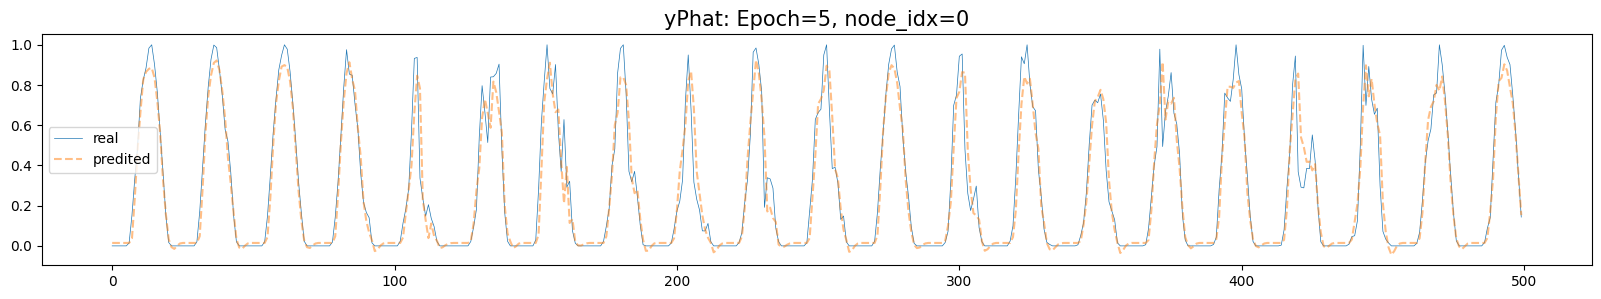

In [207]:
t_ = 500

with plt.style.context('default'): 
        plt.ioff()
        plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
        fig,ax = plt.subplots()
        plt.plot(yP[:t_,node_idx],label='real',lw=0.5)
        plt.plot(yPhat[:t_,node_idx],'--',label='predited',alpha=0.5)
        ax.set_title(f'yPhat: Epoch={epochs}, node_idx={node_idx}',size=15)
        ax.legend()

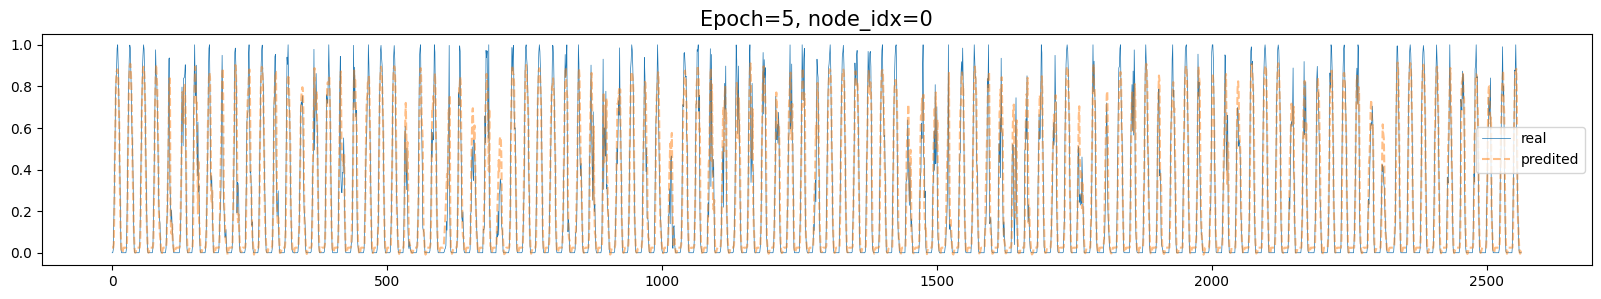

In [22]:
lrnr.figs[-1]

`-` yUhat\*yPhat

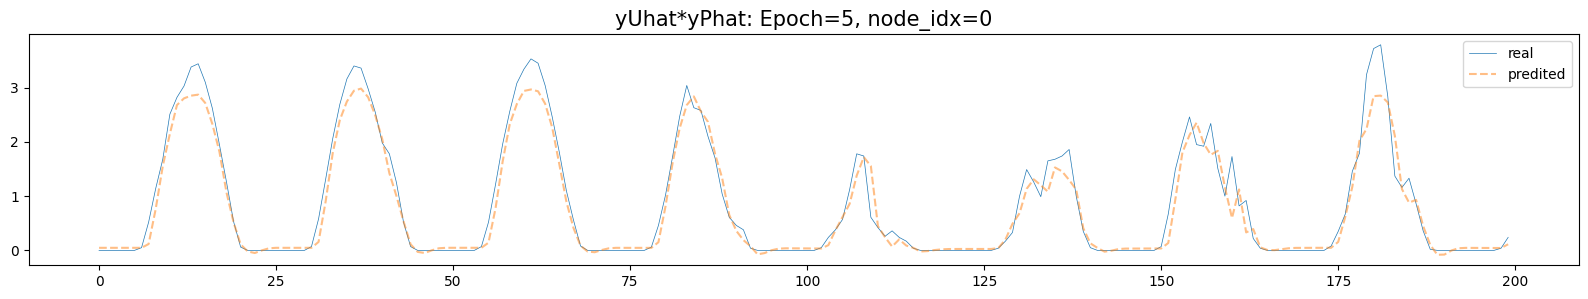

In [212]:
t_ = 200

with plt.style.context('default'): 
        plt.ioff()
        plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
        fig,ax = plt.subplots()
        plt.plot(y[:t_,node_idx],label='real',lw=0.5)
        plt.plot((yUhat*yPhat)[:t_, node_idx],'--',label='predited',alpha=0.5)
        ax.set_title(f'yUhat*yPhat: Epoch={epochs}, node_idx={node_idx}',size=15)
        ax.legend()

`-` classic vs. proposed

In [208]:
((lrnr.y - yUhat_*yPhat_)**2).mean()

In [430]:
lrnr.y.shape

In [238]:
classic = ((y - yhat)[LEN_TR:,:]**2).mean()
proposed = ((y - yUhat*yPhat)[LEN_TR:,:]**2).mean()
print('classic(mse)', round(classic,4))
print('proposed(mse)', round(proposed,4))

classic(mse) 0.0613
proposed(mse) 0.0497

`-` 에폭 별 loss

In [231]:
lrnr.losses

## Edit rgcn()

`-` learn

``` python
## before
class Learner:
    def __init__(self,train_dataset,dataset_name = None):
        self.train_dataset = train_dataset
        self.lags = torch.tensor(train_dataset.features).shape[-1]
    def learn(self,model,epoch=10):
        self.model = model 
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.model.train()
        for e in range(epoch):
            for snapshot in self.train_dataset:
                yt_hat = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
                cost = torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                cost.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            print('{}/{}'.format(e+1,epoch),end='\r')
    def __call__(self,dataset):
        X = torch.tensor(dataset.features).float()
        y = torch.tensor(dataset.targets).float()
        yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr) for snapshot in dataset]).detach().squeeze().float()
        return {'X':X, 'y':y, 'yhat':yhat} 

# learn 
def rgcn(FX,model,train_ratio,lags,epoch):
    dct = makedict(FX=FX.tolist())
    loader = Loader(dct)
    dataset = loader.get_dataset(lags=lags)
    dataset_tr, dataset_test = torch_geometric_temporal.temporal_signal_split(dataset, train_ratio = train_ratio)
    lrnr = Learner(dataset_tr)
    lrnr.learn(model,epoch)
    yhat = np.array(lrnr(dataset)['yhat'])
    yhat = np.concatenate([np.array([list(yhat[0])]*lags),yhat],axis=0)
    return yhat
```

In [6]:
# learn 
def rgcn(FX, model, train_ratio, lags, filters, epoch):
    # step1: create lrnr object
    lrnr = RGCN_Learner()
    # step2: load data
    lrnr.lags = lags
    lrnr.train_ratio = train_ratio
    lrnr.load(FX)
    # step3: construct networks
    lrnr.nof_filters = filters
    lrnr.model = model(node_features=lrnr.lags, filters=lrnr.nof_filters).to(device)
    lrnr.optimizer = torch.optim.Adam(lrnr.model.parameters(), lr=10/1000)
    # step4: learn
    lrnr.get_batches(batch_size=24)
    for e in range(epoch):
        lrnr.learn()
    yhat = np.concatenate([np.array([list(lrnr.yhat[0])]*lrnr.lags),lrnr.yhat],axis=0)
    return yhat

In [306]:
# hyper params
LAGS = 4
FILTERS = 16
EPOCH = 5

`-` classic

In [307]:
yhat = rgcn(y, GConv_GRU, train_ratio = TRAIN_RATIO, lags=LAGS, filters = FILTERS, epoch=EPOCH)
yhat[yhat<0] = 0

epoch=1  loss=0.478295594150590364325256        
epoch=2  loss=0.11286048647449468260727         
epoch=3  loss=0.102452187040864031437073        
epoch=4  loss=0.097044803375421572805786        
epoch=5  loss=0.092968239513940599723053        

In [308]:
epochs = lrnr.epochs
node_idx = 0

def rslt_plot(y, yhat, t_):
    with plt.style.context('default'): 
            plt.ioff()
            plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
            fig,ax = plt.subplots()
            ax.plot(y[:t_,node_idx],label='real',lw=0.5)
            ax.plot(yhat[:t_,node_idx],'--',label='predited',alpha=0.5)
            ax.set_title(f'Epoch={epochs}, node_idx={node_idx}',size=15)
            ax.legend()

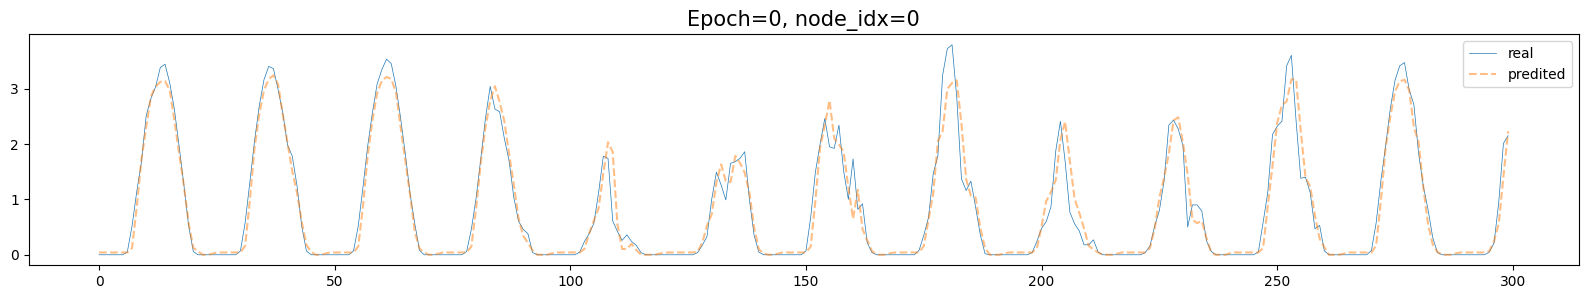

In [309]:
rslt_plot(y, yhat_ex, 300)

`-` proposed

In [311]:
# 방법2 
yUhat = rgcn(yU, GConv_GRU, train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH)

yPhat = rgcn(yP, GConv_GRU, train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH)
yPhat[yPhat < 0] =0 

classic = ((y - yhat)[LEN_TR:, :] ** 2)
proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

# print mse
print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))

epoch=1  loss=1.30948213700118440220375         
epoch=2  loss=0.1094538475018601052129745   
epoch=3  loss=0.0654008990088694382478523   
epoch=4  loss=0.0460142983600150737734032   
epoch=5  loss=0.0386558600517293859718323       
epoch=1  loss=0.0213938124835231269302063       
epoch=2  loss=0.0120059160358640690018806       
epoch=3  loss=0.0117051270763324852077103       
epoch=4  loss=0.0114985625151284948926163       
epoch=5  loss=0.0113080940507135774993477       

total_mse(classic): 0.0583
total_mse(proposed): 0.0478


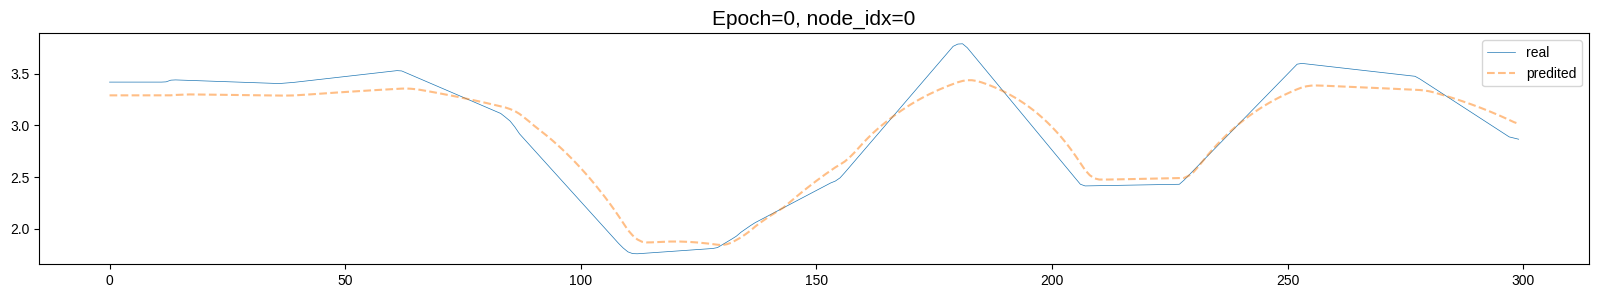

In [319]:
rslt_plot(yU, yUhat, 300)

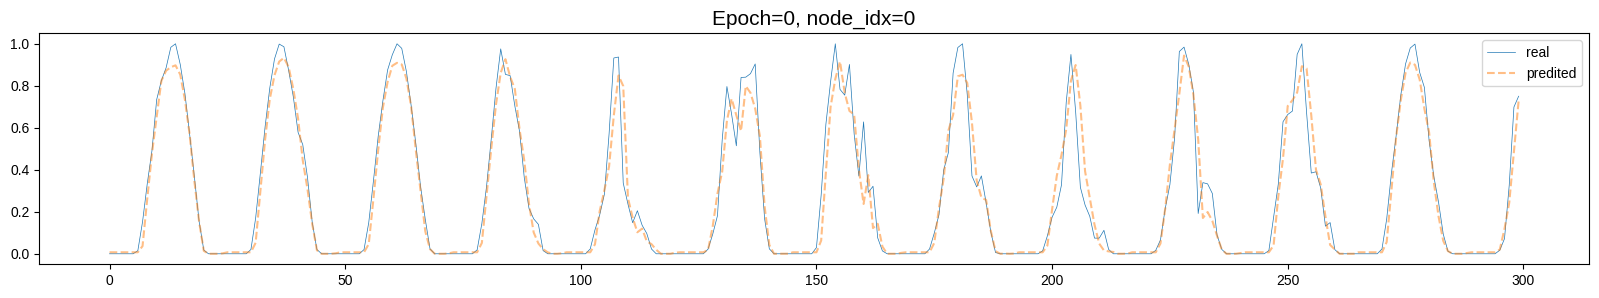

In [320]:
rslt_plot(yP, yPhat, 300)

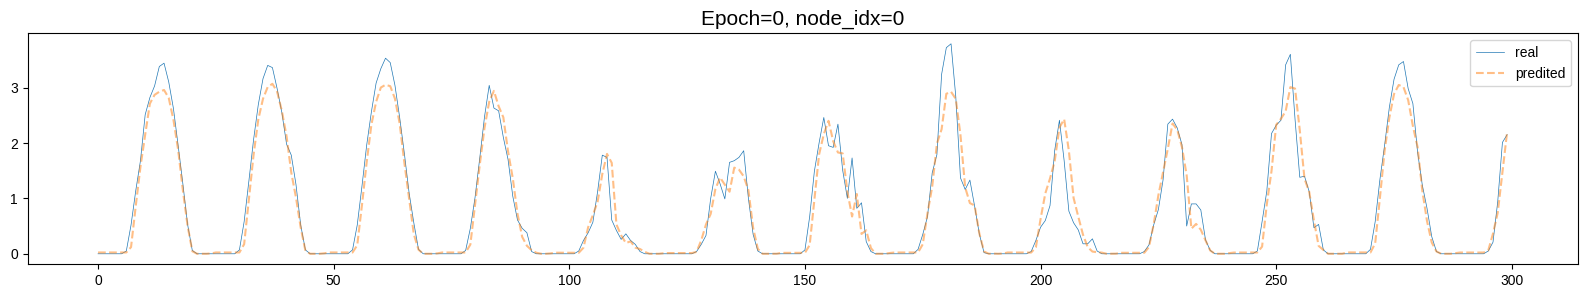

In [321]:
rslt_plot(y, yUhat*yPhat, 300)

## simul code

``` python
class Simulator:
    def __init__(self):
        self.col = ['model', 'method', 'lags', 
       'nof_filters', 'epoch', 'calculation_time',
       'index_time',
       'node', 'mse']
        self.df = pd.DataFrame(columns=self.col)
        self.data = pd.read_csv('data_eng_230710.csv')
    
    def simulate(self,n_iteration,lags,filters,epoch,Model):

        # make y, y_upper, y_period, time, regions 
        y = self.data.loc[:,'Bukchoncheon':'Gyeongju-si'].to_numpy()
        yU = self.data.loc[:,'Bukchoncheon_Upper':'Gyeongju-si_Upper'].to_numpy()
        yP = np.divide(y, yU+1e-10)
        t = self.data.loc[:,'date']
        regions = list(self.data.loc[:,'Bukchoncheon':'Gyeongju-si'].columns)
        
        TRAIN_RATIO = 0.8
        T,N = len(t),len(regions) 
        LEN_TEST = int(np.floor(T*(1-TRAIN_RATIO)))
        LEN_TR = T - LEN_TEST        
        
        self.n_iteration = n_iteration
        self.method = ['classic','proposed']
        self.lags = lags
        self.filters = filters
        self.epoch = epoch
        self.Model = Model
        model_name= Model.__name__.replace('_','')
        # model_name = 'GConvGRU'

        for iteration in range(n_iteration):
            for m,l,f,e in itertools.product(self.method, self.lags, self.filters, self.epoch):
                if m == 'classic':
                    t1 = time.time()
                    model = self.Model(node_features=l, filters=f) 
                    # model = GConv_GRU(node_features=l, filters=f)
                    yhat = rgcn(y, model = model, train_ratio = TRAIN_RATIO, lags=l, epoch=e)
                    yhat[yhat < 0]= 0   
                    t2 = time.time()
                    c = t2-t1
                    t = str(datetime.datetime.now())
                    _df2 = pd.concat([pd.Series(regions),pd.Series(((y - yhat)[LEN_TR:, :] ** 2).mean(axis=0))],axis=1)
                    _df1 = pd.DataFrame([[model_name,m,l,f,e,c,t]]*N)
                    _df = pd.concat([_df1,_df2],axis=1).set_axis(self.col,axis=1)
                    self.df = pd.concat([self.df,_df])
                else: # proposed 
                    t1 = time.time()
                    model = self.Model(node_features=l, filters=f)
                    # model = GConv_GRU(node_features=l, filters=f)
                    yUhat = rgcn(yU, model = model, train_ratio = 0.8, lags=l, epoch=e)
                    model = self.Model(node_features=l, filters=f)
                    # model = GConv_GRU(node_features=l, filters=f)
                    yPhat = rgcn(yP, model = model, train_ratio = 0.8, lags=l, epoch=e)
                    yPhat[yPhat < 0] =0 
                    yhat = yUhat*yPhat
                    t2 = time.time()
                    c = t2-t1
                    t = str(datetime.datetime.now())
                    _df2 = pd.concat([pd.Series(regions),pd.Series(((y - yhat)[LEN_TR:, :] ** 2).mean(axis=0))],axis=1)
                    _df1 = pd.DataFrame([[model_name,m,l,f,e,c,t]]*N)
                    _df = pd.concat([_df1,_df2],axis=1).set_axis(self.col,axis=1)
                    self.df = pd.concat([self.df,_df])
                print("method:{} lag:{} filters:{} epoch:{} is done".format(m,l,f,e))        
            # self.df = self.df.groupby('index_time').agg({'mse':np.mean}).reset_index().rename({'mse':'mse_mean'},axis=1).merge(self.df)
            self.df.to_csv("./results/SOLAR_{}.csv".format(str(pd.to_datetime(datetime.datetime.now())) + str('_') + model_name.lower()),index=False)
            print("save results")
```

In [7]:
# for simulation
import itertools
import time
import datetime

class Simulator:
    def __init__(self):
        self.col = ['model', 'method', 'lags', 
       'nof_filters', 'epoch', 'calculation_time',
       'index_time',
       'node', 'mse']
        self.df = pd.DataFrame(columns=self.col)
        self.data = pd.read_csv('data_eng_230710.csv')
    
    def simulate(self,n_iteration,lags,filters,epoch,Model):

        # make y, y_upper, y_period, time, regions 
        y = self.data.loc[:,'Bukchoncheon':'Gyeongju-si'].to_numpy()
        yU = self.data.loc[:,'Bukchoncheon_Upper':'Gyeongju-si_Upper'].to_numpy()
        yP = np.divide(y, yU+1e-10)
        t = self.data.loc[:,'date']
        regions = list(self.data.loc[:,'Bukchoncheon':'Gyeongju-si'].columns)
        
        TRAIN_RATIO = 0.8
        T,N = len(t),len(regions) 
        LEN_TEST = int(np.floor(T*(1-TRAIN_RATIO)))
        LEN_TR = T - LEN_TEST        
        
        self.n_iteration = n_iteration
        self.method = ['classic','proposed']
        self.lags = lags
        self.filters = filters
        self.epoch = epoch
        self.Model = Model
        model_name= Model.__name__.replace('_','')

        for iteration in range(n_iteration):
            for m,l,f,e in itertools.product(self.method, self.lags, self.filters, self.epoch):
                if m == 'classic':
                    t1 = time.time()
                    # model = self.Model(node_features=l, filters=f) 
                    # yhat = rgcn(y, model = model, train_ratio = TRAIN_RATIO, lags=l, epoch=e)
                    yhat = rgcn(y, Model, train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH)
                    yhat[yhat < 0]= 0   
                    t2 = time.time()
                    c = t2-t1
                    t = str(datetime.datetime.now())
                    _df2 = pd.concat([pd.Series(regions),pd.Series(((y - yhat)[LEN_TR:, :] ** 2).mean(axis=0))],axis=1)
                    _df1 = pd.DataFrame([[model_name,m,l,f,e,c,t]]*N)
                    _df = pd.concat([_df1,_df2],axis=1).set_axis(self.col,axis=1)
                    self.df = pd.concat([self.df,_df])
                else: # proposed 
                    t1 = time.time()
                    # model = self.Model(node_features=l, filters=f)
                    # yUhat = rgcn(yU, model = model, train_ratio = 0.8, lags=l, epoch=e)
                    yUhat = rgcn(yU, Model, train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH)
                    # model = self.Model(node_features=l, filters=f)
                    # yPhat = rgcn(yP, model = model, train_ratio = TRAIN_RATIO, lags=l, epoch=e)
                    yPhat = rgcn(yP, Model, train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH)
                    yPhat[yPhat < 0] =0 
                    yhat = yUhat*yPhat
                    t2 = time.time()
                    c = t2-t1
                    t = str(datetime.datetime.now())
                    _df2 = pd.concat([pd.Series(regions),pd.Series(((y - yhat)[LEN_TR:, :] ** 2).mean(axis=0))],axis=1)
                    _df1 = pd.DataFrame([[model_name,m,l,f,e,c,t]]*N)
                    _df = pd.concat([_df1,_df2],axis=1).set_axis(self.col,axis=1)
                    self.df = pd.concat([self.df,_df])
                print("method:{} lag:{} filters:{} epoch:{} is done".format(m,l,f,e))        
            # self.df = self.df.groupby('index_time').agg({'mse':np.mean}).reset_index().rename({'mse':'mse_mean'},axis=1).merge(self.df)
            self.df.to_csv("./results/SOLAR_{}.csv".format(str(pd.to_datetime(datetime.datetime.now())) + str('_') + model_name.lower()),index=False)
            print("save results")

`-` test1

In [326]:
s1 = Simulator()

In [327]:
s1.simulate(
    n_iteration = 1,
    lags = [2],
    filters = [4],
    epoch = [5],
    Model = GConv_GRU
)

epoch=1  loss=0.320828506246555740200806    
epoch=2  loss=0.10598197232845218088333         
epoch=3  loss=0.09605887805133365352951             
epoch=4  loss=0.088832432967285787079773            
epoch=5  loss=0.08655679351541885576187             
method:classic lag:2 filters:4 epoch:5 is done
epoch=1  loss=2.065562172078116855487823    
epoch=2  loss=0.099672921911575081571331        
epoch=3  loss=0.06757946603736559198658         
epoch=4  loss=0.0511718820997102357834015   
epoch=5  loss=0.043731608157327705176897        
epoch=1  loss=0.0193107868761344328121185       
epoch=2  loss=0.012312771544012046496685            
epoch=3  loss=0.0120556999165781365204773       
epoch=4  loss=0.0118642051184419979035492       
epoch=5  loss=0.0116530259296861150664597       
method:proposed lag:2 filters:4 epoch:5 is done
save results

In [338]:
import os
fnames = ['./results/'+l for l in os.listdir('./results/') if l[0] != '.'][1]
fnames 

In [355]:
# 시뮬 결과 test1
df = pd.read_csv(fnames).reset_index(drop=True)
df.head()

In [342]:
df.groupby(by=['method']).agg({'mse':[np.mean]})

`-` test2

In [356]:
s2 = Simulator()

In [357]:
s2.simulate(
    n_iteration = 2,
    lags = [2, 4],
    filters = [4, 8],
    epoch = [5],
    Model = GConv_GRU
)

epoch=1  loss=0.499347933373132448674316            
epoch=2  loss=0.103811736500193990999603        
epoch=3  loss=0.097780641254990664478302            
epoch=4  loss=0.094741307848761256512604            
epoch=5  loss=0.0920923451871373034729  6           
method:classic lag:2 filters:4 epoch:5 is done
epoch=1  loss=0.54959914148893468283844             
epoch=2  loss=0.130603338093605169658203        
epoch=3  loss=0.1074600968683181982576  8       
epoch=4  loss=0.099699616735411256355286        
epoch=5  loss=0.095006868329852130921478            
method:classic lag:2 filters:8 epoch:5 is done
epoch=1  loss=0.376909123127197168920898        
epoch=2  loss=0.112543174737068111595764        
epoch=3  loss=0.10071836048087408938095         
epoch=4  loss=0.094225898428365250027313            
epoch=5  loss=0.09053111453215744686081             
method:classic lag:4 filters:4 epoch:5 is done
epoch=1  loss=0.540919109702456847611237            
epoch=2  loss=0.11331923401286435862167

In [363]:
import os
fnames = ['./results/'+l for l in os.listdir('./results/') if l[0] != '.'][1:]
fnames 

In [365]:
# 시뮬결과 test2
df_ = pd.concat([pd.read_csv(fname) for fname in fnames]).reset_index(drop=True)

In [376]:
df_.groupby(by=['method','lags', 'nof_filters']).agg({'mse':[np.mean]})

## Ref:

<https://miruetoto.github.io/yechan3/posts/3_Researches/PINKOCTO/SOLAR/2023-08-14-EPT-GConvLSTM-setting-Copy1.out.html>

# GConvLSTM

In [10]:
# modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pytorch geometric temporal
import torch_geometric_temporal
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import GConvLSTM

# torch
import torch
import torch.nn.functional as F


# read data
def makedict(FX,W=None,node_ids=None):
    T,N = np.array(FX).shape
    if W==None:
        W = pd.DataFrame(FX).corr().to_numpy().reshape(-1).tolist() # corr 로 weights
    if node_ids==None:
        node_ids = ['node'+str(n) for n in range(N)]
    _dict={
        'edges':[[i,j] for i in range(N) for j in range(N)], 
        'node_ids': node_ids,
        'weights':W,
        'FX':FX
    }
    return _dict

class Loader(object):
    def __init__(self, data_dict):
        self._dataset = data_dict
    
    def _get_edges(self):
        self._edges = np.array(self._dataset["edges"]).T

    def _get_edge_weights(self):
        # self._edge_weights = np.array(self._dataset["weights"]).T
        edge_weights = np.array(self._dataset["weights"]).T
        #scaled_edge_weights = minmaxscaler(edge_weights)
        self._edge_weights = edge_weights

    def _get_targets_and_features(self):
        stacked_target = np.stack(self._dataset["FX"])
        self.features = np.stack([
            stacked_target[i : i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])
        self.targets = np.stack([
            stacked_target[i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])


    def get_dataset(self, lags: int = 4) -> StaticGraphTemporalSignal:
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = StaticGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        dataset.node_ids = self._dataset['node_ids']
        return dataset
    

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

class RGCN_Learner:
    def __init__(self):
        self.method = 'RecurrentGCN'
        self.figs = []
        self.epochs = 0
        self.losses = []
        self._node_idx = 0
    def load(self,y): 
        if (self.lags is None) or (self.train_ratio is None):
            self.lags = 2 
            self.train_ratio = 0.8 
        self.t,self.n = y.shape
        dct = makedict(FX=y.tolist())
        self.loader = Loader(dct)
        self.dataset = self.loader.get_dataset(lags=self.lags)
        self.X = torch.tensor(self.dataset.features).float()
        self.y = torch.tensor(self.dataset.targets).float()
        self.train_dataset, self.test_dataset = temporal_signal_split(self.dataset, train_ratio = self.train_ratio)
        self.len_test = self.test_dataset.snapshot_count
        self.len_tr = self.train_dataset.snapshot_count
    def get_batches(self, batch_size=256):
        num_batches =  self.len_tr // batch_size + (1 if self.len_tr % batch_size != 0 else 0)
        self.batches = []
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            self.batches.append(self.train_dataset[start_idx:end_idx])
    
    def learn(self,epoch=1):
        self.model.train()
        for e in range(epoch):
            losses_batch = []
            for b,batch in enumerate(self.batches):
                loss = 0
                self.h, self.c = None, None
                for t, snapshot in enumerate(batch):
                    snapshot = snapshot.to(device)
                    yt_hat, self.h, self.c = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)
                    loss = loss + torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                    print(f'\rbatch={b}\t t={t+1}\t loss={loss/(t+1)}\t', end='', flush=True)
                loss = loss / (t+1)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                losses_batch.append(loss.item())
            self.epochs = self.epochs + 1
            print(f'\repoch={self.epochs}\t loss={np.mean(losses_batch)}\n', end='', flush=True)
        self.losses.append(np.mean(losses_batch))
        self._savefigs() 
    def _savefigs(self): 
        self.__call__()
        self._node_idx
        with plt.style.context('default'): 
            plt.ioff()
            plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
            fig,ax = plt.subplots()
            ax.plot(self.y[:,self._node_idx],label='real',lw=0.5)
            ax.plot(self.yhat[:,self._node_idx],'--',label='predited',alpha=0.5)
            ax.set_title(f'Epoch={self.epochs}, node_idx={self._node_idx}',size=15)
            ax.legend()
            #mplcyberpunk.add_glow_effects()  
        self.figs.append(fig)
        plt.close()        
    def __call__(self,dataset=None):
        if dataset == None: 
            dataset = self.dataset
        self.yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)[0] for snapshot in dataset]).detach().squeeze().float()
        return {'X':self.X, 'y':self.y, 'yhat':self.yhat} 

In [11]:
class GConv_LSTM(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(GConv_LSTM, self).__init__()
        self.recurrent = GConvLSTM(in_channels = node_features, out_channels = filters, K = 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight, h, c):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h, c)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

In [12]:
# learn 
def rgcn(FX, model, train_ratio, lags, filters, epoch, batch_size=128, lr=10/1000):
    # step1: create lrnr object
    lrnr = RGCN_Learner()
    # step2: load data
    lrnr.lags = lags
    lrnr.train_ratio = train_ratio
    lrnr.load(FX)
    # step3: construct networks
    lrnr.nof_filters = filters
    lrnr.model = model(node_features=lrnr.lags, filters=lrnr.nof_filters).to(device)
    lrnr.optimizer = torch.optim.Adam(lrnr.model.parameters(), lr=lr)
    # step4: learn
    lrnr.get_batches(batch_size=batch_size)
    for e in range(epoch):
        lrnr.learn()
    yhat = np.concatenate([np.array([list(lrnr.yhat[0])]*lrnr.lags),lrnr.yhat],axis=0)
    return yhat

In [23]:
# for simulation
import itertools
import time
import datetime

class Simulator:
    def __init__(self):
        self.col = ['model', 'method', 'lags', 
       'nof_filters', 'epoch', 'lr', 'calculation_time',
       'index_time',
       'node', 'mse']
        self.df = pd.DataFrame(columns=self.col)
        self.data = pd.read_csv('data_eng_230710.csv')
    
    def simulate(self,n_iteration,lags,filters,epoch,Model,lr):

        # make y, y_upper, y_period, time, regions 
        y = self.data.loc[:,'Bukchoncheon':'Gyeongju-si'].to_numpy()
        yU = self.data.loc[:,'Bukchoncheon_Upper':'Gyeongju-si_Upper'].to_numpy()
        yP = np.divide(y, yU+1e-10)
        t = self.data.loc[:,'date']
        regions = list(self.data.loc[:,'Bukchoncheon':'Gyeongju-si'].columns)
        
        TRAIN_RATIO = 0.8
        T,N = len(t),len(regions) 
        LEN_TEST = int(np.floor(T*(1-TRAIN_RATIO)))
        LEN_TR = T - LEN_TEST        
        
        self.n_iteration = n_iteration
        self.method = ['classic','proposed']
        self.lags = lags
        self.filters = filters
        self.epoch = epoch
        self.Model = Model
        self.lr = lr
        model_name= Model.__name__.replace('_','')

        for iteration in range(n_iteration):
            for m,l,f,e in itertools.product(self.method, self.lags, self.filters, self.epoch):
                if m == 'classic':
                    t1 = time.time()
                    model = self.Model(node_features=l, filters=f) 
                    yhat = rgcn(y, Model, train_ratio = TRAIN_RATIO, lags=l, filters=f, epoch=e, batch_size=128, lr=lr)
                    yhat[yhat < 0]= 0   
                    t2 = time.time()
                    c = t2-t1
                    t = str(datetime.datetime.now())
                    _df2 = pd.concat([pd.Series(regions),pd.Series(((y - yhat)[LEN_TR:, :] ** 2).mean(axis=0))],axis=1)
                    _df1 = pd.DataFrame([[model_name,m,l,f,e,lr,c,t]]*N)
                    _df = pd.concat([_df1,_df2],axis=1).set_axis(self.col,axis=1)
                    self.df = pd.concat([self.df,_df])
                else: # proposed 
                    t1 = time.time()
                    yUhat = rgcn(yU, Model, train_ratio = TRAIN_RATIO, lags=4, filters=f, epoch=5, batch_size=24, lr=lr)
                    yPhat = rgcn(yP, Model, train_ratio = TRAIN_RATIO, lags=l, filters=f, epoch=e, batch_size=128, lr=lr)
                    yPhat[yPhat < 0] =0 
                    yhat = yUhat*yPhat
                    t2 = time.time()
                    c = t2-t1
                    t = str(datetime.datetime.now())
                    _df2 = pd.concat([pd.Series(regions),pd.Series(((y - yhat)[LEN_TR:, :] ** 2).mean(axis=0))],axis=1)
                    _df1 = pd.DataFrame([[model_name,m,l,f,e,lr,c,t]]*N)
                    _df = pd.concat([_df1,_df2],axis=1).set_axis(self.col,axis=1)
                    self.df = pd.concat([self.df,_df])
                print("method:{} lag:{} filters:{} epoch:{} is done".format(m,l,f,e))        
            self.df.to_csv(f"./results/glstm/SOLAR_{str(pd.to_datetime(datetime.datetime.now())) + str('_') + model_name.lower()}.csv",index=False)
            print("save results")

In [24]:
s2 = Simulator()

In [25]:
s2.simulate(
    n_iteration = 1,
    lags = [24],
    filters = [4],
    epoch = [1],
    Model = GConv_LSTM,
    lr = 10/1000
)

epoch=1  loss=0.804348416626453416119385        
method:classic lag:24 filters:4 epoch:1 is done
epoch=1  loss=3.53389973037464799645996     
epoch=2  loss=0.93540121129778935005493     
epoch=3  loss=0.298869785787754340306854    
epoch=4  loss=0.1225418915842161655587006   
epoch=5  loss=0.064804968099261446246643        
epoch=1  loss=0.08347747800871739982938766  
method:proposed lag:24 filters:4 epoch:1 is done
save results

In [27]:
import os
fnames = ['./results/glstm/'+l for l in os.listdir('./results/glstm') if l[0] != '.']
fnames 

In [28]:
# 시뮬결과 test
df2 = pd.concat([pd.read_csv(fname) for fname in fnames]).reset_index(drop=True)

In [29]:
df2.groupby(by=['method']).agg({'mse':[np.mean]})

-   test완료

# GCLSTM

In [ ]:
class GC_LSTM(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(GC_LSTM, self).__init__()
        self.recurrent = GCLSTM(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight, h, c):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h, c)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

# LRGCN

In [ ]:
class LR_GCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(LR_GCN, self).__init__()
        self.recurrent = LRGCN(node_features, filters, 1, 1)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight, h_0, c_0):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h_0, c_0)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

# TGCN

In [ ]:
class T_GCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(T_GCN, self).__init__()
        self.recurrent = TGCN(node_features, filters)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight, prev_hidden_state):
        h = self.recurrent(x, edge_index, edge_weight, prev_hidden_state)
        y = F.relu(h)
        y = self.linear(y)
        return y, h

In [34]:
s5 = Simulator()

In [35]:
s5.simulate(
    n_iteration = 1,
    lags = [24],
    filters = [4],
    epoch = [1],
    Model = T_GCN,
    lr = 10/1000
)

epoch=1  loss=1.160145100206136775190735        
method:classic lag:24 filters:4 epoch:1 is done
epoch=1  loss=1.4286022151625433300766          
epoch=2  loss=0.58079827975395124142761     
epoch=3  loss=0.56894418909106152565613     
epoch=4  loss=0.52527498887028877774048     
epoch=5  loss=0.432140358138916134414673    
epoch=6  loss=0.29863016653892605328766     
epoch=7  loss=0.274782096663879886978912        
epoch=8  loss=0.269868740465405415579224        
epoch=9  loss=0.270463947336687658974457        
epoch=10     loss=0.26475534120271372154083     
epoch=1  loss=0.1617825529538095571460724       
method:proposed lag:24 filters:4 epoch:1 is done
save results

In [36]:
fnames = ['./results/tgcn/'+l for l in os.listdir('./results/tgcn') if l[0] != '.']
fnames

In [37]:
df_t = pd.concat([pd.read_csv(fname) for fname in fnames]).reset_index(drop=True)

In [39]:
df_t.groupby(by=['method']).agg({'mse':[np.mean]})

In [ ]:
class DC_RNN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(DC_RNN, self).__init__()
        self.recurrent = DCRNN(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h